In [65]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

## 掩蔽softmax操作
---

In [66]:
def sequence_mask(X, valid_len, value=0):
    """在序列中遮蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

In [67]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    ## X: 3D张量 valid_lens: 1D或2D张量
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    shape = X.shape
    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return F.softmax(X.reshape(shape), dim=-1)

In [68]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2,3]))

tensor([[[0.6181, 0.3819, 0.0000, 0.0000],
         [0.4994, 0.5006, 0.0000, 0.0000]],

        [[0.3496, 0.2818, 0.3687, 0.0000],
         [0.3800, 0.3695, 0.2505, 0.0000]]])

In [69]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1,3], [2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2047, 0.4886, 0.3067, 0.0000]],

        [[0.5484, 0.4516, 0.0000, 0.0000],
         [0.2795, 0.2698, 0.2831, 0.1676]]])

## 加性注意力
---

In [70]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

In [71]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        ## 在维度扩展后，queries的形状: (batch_size, 查询个数, 1, num_hidden)
        ## keys的形状: (batch_size, 1, 键值对的个数, num_hiddens), 使用广播机制求和
        features = queries.unsqueeze(2)+keys.unsqueeze(1)
        features = torch.tanh(features)
        ## self.w_v仅有一个输出,因此从形状中移除最后那个维度
        ## scores的形状: (batch_size, 查询的个数, 键值对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        ## values的形状: (batch_size, 键值对个数, 值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [72]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2,10,2))
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2, 1, 1)
valid_lens = torch.tensor([2,6])
attention = AdditiveAttention(
    key_size=2,
    query_size=20,
    num_hiddens=8,
    dropout=0.1
)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

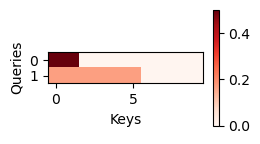

In [73]:
show_heatmaps(
    attention.attention_weights.reshape(1,1,2,10),
    xlabel='Keys',
    ylabel='Queries'
)

## 缩放点积注意力
---

In [74]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens=None):
        ## queries的形状: (batch_size, 查询个数, d)
        ## keys的形状: (batch_size, 键值对个数, d)
        ## values的形状: (batch_size, 键值对个数, 值的维度)
        ## valid_lens的形状: (batch_size,)或(batch_size, 查询个数)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [75]:
queries, keys = torch.normal(0, 1, (2,1,2)), torch.ones((2,10,2))
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2, 1, 1)
valid_lens = torch.tensor([2,6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(
    queries, keys, values, valid_lens
)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

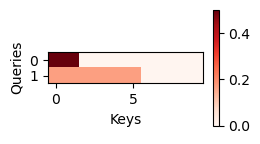

In [76]:
show_heatmaps(
    attention.attention_weights.reshape(1,1,2,10),
    xlabel='Keys',
    ylabel='Queries'
)

## Exercises
---

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？

2. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？

3. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？